In [1]:
import os
from pathlib import Path
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt
import scipy.signal as ss

# plt.rcParams['figure.figsize'] = [10, 5]
# plt.rcParams['figure.dpi'] = 100

%matplotlib inline

## Goal
- reflectance = (raw data - dark reference) / (white reference - dark reference)
- **reflectance = Radiance data / White Reference**
- reflectance = (... pending empirical line)

### Working Paths
- Load calibrated panel, Kestrel Raw dataset, File list, Out Path

In [20]:
calibrated_whiteref = np.load(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\Spectralon\WhitePanel.npy")
files_path = Path(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\Kestrel-Radiance")
out_path = Path(r"C:\Users\jcmontes\OneDrive - University of Tasmania\01_Projects_Drive\Imaging_spectroscopy\Phenotyping_macroalgae\data\NIWA-Antarctic-CCA\Output")

files_list = os.listdir(files_path)

### Target paths

In [23]:
target_path = files_path # Radiance dataset

#target_path = files_path / files_list[0] / 'calibrations' # For raw dataset
#target_path

hdr_list = list(target_path.glob('*.HDR'))
rad_list = list(target_path.glob('*.DAT')) #.dat for radiance

In [24]:
len(hdr_list)

18

### Open image and dark reference

- RAW (DN): Each folder contain a dark reference and the image acquired.

In [27]:
i = 17

In [28]:
# Assign variable names to each file and open them with spectral python
#hdr_list = list(target_path.glob('*.hdr'))
#raw_list = list(target_path.glob('*.raw'))

# Dark reference
#target_dark_hdr = hdr_list[0]
#target_dark_raw = raw_list[0]
#target_dark_open = sp.envi.open(target_dark_hdr, target_dark_raw)

## Imaging target
target_hdr = hdr_list[i]
target_raw = rad_list[i]
target_open = sp.envi.open(target_hdr, target_raw)

## See what file we are processing
target_hdr

WindowsPath('C:/Users/jcmontes/OneDrive - University of Tasmania/01_Projects_Drive/Imaging_spectroscopy/Phenotyping_macroalgae/data/NIWA-Antarctic-CCA/Kestrel-Radiance/NIWA-CCA_WhiteReference_2004-08-06_00-36-15_radiance.hdr')

394.360000 nm to 1001.960000 nm


ImageView object:
  Display bands       :  [144, 92, 42]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2900.0]
    G: [0.0, 1798.0]
    B: [0.0, 802.0]

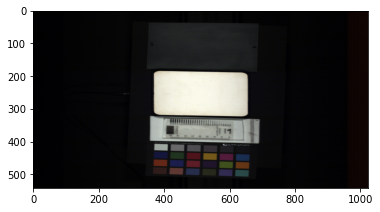

In [29]:
target_bands = target_open.metadata['wavelength']
print(target_bands[0], 'nm to', target_bands[-1], 'nm')
sp.imshow(target_open)

ImageView object:
  Display bands       :  [0, 178.0, 355]
  Interpolation       :  <default>
  RGB data limits     :
    R: [15.0, 432.0]
    G: [1732.0, 3508.0]
    B: [2881.0, 4832.0]

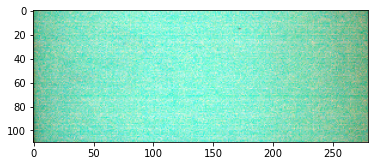

In [44]:
sp.imshow(target_open[200:310,370:650,:])

### Load data

In [16]:
#target_dark_data = target_dark_open.load()
#target_darkref = target_dark_data.mean(axis=(0, 1))

In [45]:
target_data = target_open.load()
target_data = target_data[200:310,370:650,:]

ImageView object:
  Display bands       :  (239, 173, 120)
  Interpolation       :  <default>
  RGB data limits     :
    R: [2259.0, 4063.0]
    G: [1676.0, 3453.0]
    B: [1094.0, 2388.0]

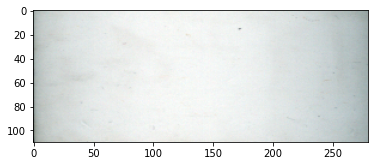

In [46]:
#%matplotlib notebook
sp.imshow(target_data,(239,173,120))

### Reshape or unfold for calibration and reflectance conversion
- Use of reshape method. Notice the use of -1 for the 0th dimension.
- States that is an unknown number of rows with bands as the columns.

In [18]:
unfold_target = target_data.reshape(-1,len(target_bands))
unfold_target.shape

(262350, 356)

In [19]:
target_minus_dark = unfold_target - target_darkref

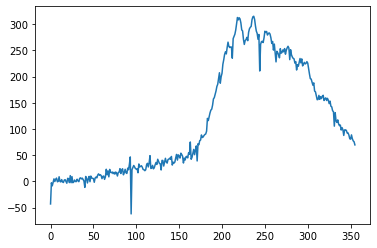

In [20]:
plt.plot(target_minus_dark[100])

## Reflectance conversion
- Reaching the goal of this notebook

In [21]:
## Use of calibrated white reference panel
reflectance = np.divide(target_minus_dark, calibrated_whiteref)

ImageView object:
  Display bands       :  (239, 173, 120)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.020250292494893074, 0.829693615436554]
    G: [-0.033553533256053925, 0.9107822179794312]
    B: [-0.04375499486923218, 0.8387548923492432]

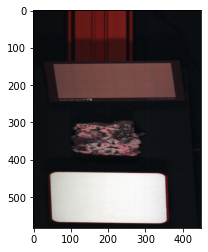

In [22]:
%matplotlib inline
reflectance = np.reshape(reflectance, target_data.shape)
sp.imshow(reflectance,(239,173,120))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


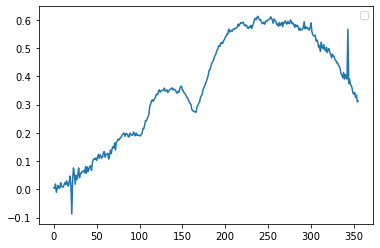

In [25]:
## Choosing a center pixel to see signal
plt.plot(reflectance[371][249])
#plt.plot(reflectance[500][250], label='Shadow')
plt.legend()

In [ ]:
Do the spectral signature, from the region where I scraped.

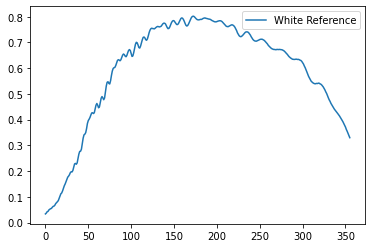

In [64]:
# Observing the whole spectralon spectra
reflectance_t = reflectance.mean(axis=(0, 1))
plt.plot(reflectance_t, label='White Reference')
plt.legend()

In [58]:
#t = 0.0 #threshold for shadows
#reflectance = (reflectance > t) * reflectance

#### Cropping final image, not masking

In [ ]:
# Cropping central region of the image, next notebook and scripts should resolve the masking 
#reflectance = reflectance[0:,500:1500,:] ## Y1:Y2,X1:X2,All bands
sp.imshow(reflectance,(33,66,99), stretch=0.05)

## Save calibrated reflectance image

In [ ]:
os.chdir(out_path)

In [ ]:
np.save(files_list[0], reflectance)

In [ ]:
# files_list[i]
sp.envi.save_image(files_list[0]+'.hdr', reflectance, interleave='bil', metadata=target_open.metadata)

## End of notebook